# Notebook 2 - Distraction Analysis

**Written by Paula T. Wang, October 2022** 

This notebook is the **second** in a series of **seven** notebooks used for the analysis for the thesis titled: *Examining Network Connectivity Patterns in Response to ‘Flow’: An fMRI Replication Study with Implications for the Synchronization Theory of Flow*

The completed thesis is published here: https://www.proquest.com/docview/2774241697/8E7945A29DCA45A3PQ/1?accountid=14522

# Introduction

This notebook is the pipeline used to prepare and analyze participant **distraction** during the experiment. Distraction is operationally defined as the demand on attentional capacity during a primary task activity. Distraction can be calculated when participants are engaged in a primary task while simultaneously responding to a secondary distractor task. 

**Procedure**

While playing a lab-designed video game, [Asteriod Impact](https://github.com/asteroidimpact/asteroid_impact_py3), Participants were required to respond to an audiovisual red light stimulus appearing equally and randomly within one of the four quadrants of their screen. Delays in the presentation of the red light stimulus, measured as the inter-stimulus interval (ISI), were randomized using a truncated Gaussian probability distribution. In response to the red light stimulus, participants were required to do a button-press with their non-dominant hand. Secondary task reaction time (STRT) was determined as the period spanning the onset of a stimulus to the subsequent button press. The present study uses STRT and ISI as input variables within the distraction index. 

**Calculating Distraction**

The distraction index is a function of the mean time interval between red light stimuli and mean response time to each presentation such that distraction increases when participants respond increasingly faster to increased presentation trials of the distractor task. Statistically, we calculate D as the inverse of the mean time interval between laser light presentations (ISI) multiplied by the mean response time to each presentation of the laser light (STRT):

$$D_{\Delta t} = \frac{1}{ \bar{ISI} \times \bar{STRT} }$$

This results in a distraction parameter (D) that serves as an input into the psychophysiological interaction model for the analysis in Notebook 3, 4 and 5. 

The more laser light presentations (ISI → 0) and the faster participants’ response to those laser light presentations (STRT → 0) the higher the distraction from the primary experimental task and the higher D is within sliding window Δt. For the purposes of this study, distraction is calculated over a constant 10 second sliding (or overlapping) window (Δt). Given that humans are resource capacity limited ([Lang, 2000](https://doi.org/10.1111/j.1460-2466.2000.tb02833.x)), an increase in distraction results in a strain on cognitive resources such that the participant is forced to divert attentional resources away from a primary task. 


**<mark>NOTE:</mark> This notebook assumes that the following processes have already been run:**
1. Fmriprep preprocessing pipeline (~/projects/thesis/code/preprocessing/preproc.ipynb)

# Import Libraries

In [1]:
import glob
import numpy as np
import pandas as pd
from datetime import timedelta
from itertools import chain
from os.path import join as opj

data_path = '/home/pw/projects/thesis/data/behavioral/rt_logs/'
out_path = '/home/pw/projects/thesis/data/behavioral/processed/'

# Prepare Psychological Regressor

## Organize RT Data

In [2]:
rt_files = [i for i in glob.glob(data_path + f'*.csv')] 
cond_list = [[file.split("_")[-2] for i in range(len(pd.read_csv(file)))] for file in rt_files]

# create raw df
rt_data_raw = pd.concat([pd.read_csv(f) for f in rt_files])
rt_data_raw['cond'] = list(chain.from_iterable(cond_list)) # add conditions from filename
print('Shape is {}'.format(rt_data_raw.shape))

Shape is (7344, 17)


### Apply conditions values
- cond1 = flow
- cond2 = boredom
- cond3 = frustration

In [3]:
def apply_conditions(df):
    df['flow'] = np.where(df.cond == 'cond1', 1, 0)
    df['bore'] = np.where(df.cond == 'cond2', 1, 0)
    df['frust'] = np.where(df.cond == 'cond3', 1, 0)
    
    conditions = [(df.flow == 1),
                  (df.bore == 1),
                  (df.frust == 1)]
    values = ['Flow','Boredom','Frustration']
    
    df['condition'] = np.select(conditions, values)
    
    return df

rt_data_conditions = apply_conditions(rt_data_raw)
print('Shape is {}'.format(rt_data_conditions.shape))

Shape is (7344, 21)


### Filter subjects
Filter subjects for non-compliance and remove training rows

In [4]:
def filter_data(df):
    # remove subjects for non-compliance
    subs = [10]
    df = df[~df.subject_number.isin(subs)]
    print('After removing non-compliant subjects, shape is {}.'.format(df.shape))
    # remove training rows
    train = [3,7]
    df = df[~df.step_number.isin(train)]
    print('After removing training rows, shape is {}'.format(df.shape))
    
    return df

rt_data_filt = filter_data(rt_data_conditions)

After removing non-compliant subjects, shape is (7140, 21).
After removing training rows, shape is (7140, 21)


### Add trials
Label each trial for each condition. There are 68 trials per condition.

In [5]:
def add_trial(df):
    n_subs = 35
    sort_df = df.sort_values(['subject_number', 'subject_run','total_millis'], ascending=True)
    sort_df['rt_trial'] = [i for i in range(1,69)]*3*n_subs
    
    return sort_df

rt_data_filt_trial = add_trial(rt_data_filt)
print('Shape is {}'.format(rt_data_filt_trial.shape))

Shape is (7140, 22)


### Save RT
Save organized reaction time data

In [6]:
rt_data_outfile = opj(out_path, 'rt_data.csv')
rt_data_filt_trial.to_csv(rt_data_outfile)

## Extrapolate Second-By-Second Data

In [7]:
cols = ['subject_number','subject_run','step_millis','reaction_prompt_millis','condition','rt_trial']

rt = pd.read_csv(rt_data_outfile, usecols=cols)
print(f'Shape is: {rt.shape}')
print(f'Number of Subjects is: {len(rt.subject_number.unique())}\n')

# replace runs [3,4,5] 
rt['subject_run'].replace([3,4,5],['01','02','03'], inplace=True)
rt['subject_number'][:1020] = rt['subject_number'][:1020].apply(lambda x: '00' + str(x))
rt['subject_number'][1020:] = rt['subject_number'][1020:].apply(lambda x: '0' + str(x))

Shape is: (7140, 6)
Number of Subjects is: 35



<ipython-input-7-ea43cede81ad>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rt['subject_number'][:1020] = rt['subject_number'][:1020].apply(lambda x: '00' + str(x))
<ipython-input-7-ea43cede81ad>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rt['subject_number'][1020:] = rt['subject_number'][1020:].apply(lambda x: '0' + str(x))


In [8]:
## define commonly used grouping function
def group(df, group_keys=False, as_index=False):
    return df.groupby(['subject_number','condition'], group_keys=group_keys, as_index=as_index)

## convert index to timedelta for each stimulus presentation
def timedelta_index(df):
    grouped = group(df)
    df['showtime_millis'] = grouped.apply(lambda x: x.step_millis - x.reaction_prompt_millis).round(-3)
    df['stimulus_presentation'] = 1
    df['isi_millis'] = grouped.apply(lambda x: x.showtime_millis.diff())
    df['step_millis_diff'] = grouped.apply(lambda x: x.step_millis.diff())
    df['timedelta'] = grouped.apply(lambda x: pd.to_timedelta(x.showtime_millis, unit='ms'))
    return df.set_index('timedelta', drop=True)

rt_timeindex = timedelta_index(rt)
print(f"Shape is: {rt_timeindex.shape}")

Shape is: (7140, 10)


Expand dataframe to incude consecutive seconds and extrapolate info for each column 

In [9]:
## expand dataframe to incude consecutive seconds and extrapolate info for each column 
def expand_df(df):
    grouped = group(df)
    
    # after expanding...
    ## subject_number, condition, and rt_trial get padded (i.e., copied from prev cell)
    pad = (grouped[['subject_number','subject_run','condition','rt_trial']]
           .resample('s').pad())
    
    ## step_millis gets linearly interpolated 
    linear = (grouped['step_millis']
        .apply(lambda group: group.resample('s').interpolate('linear').round()))
    
    ## stimulus presentation gets binary coded
    zero = (grouped[['stimulus_presentation']]
        .resample('s').asfreq(0))
    
    ## showtime_millis, reaction_prompt_millis, and isi_millis get NaNs in the expanded cells
    nan = (grouped[['showtime_millis','reaction_prompt_millis','isi_millis']]
        .resample('s').asfreq(np.NaN))
    
    concat = pd.DataFrame()
    for i in [pad, linear, zero, nan]:
        concat = pd.concat([concat, i], axis=1)
        
    return concat.reset_index()

rt_exp = expand_df(rt_timeindex)
print(f"Shape is: {rt_exp.shape}")

Shape is: (24605, 10)


### Rolling Time Window

Roll the data over every n seconds for a sliding window

In [10]:
def fit_timedelta_rng(df, rng):
    df = df.set_index('timedelta')
    
    pad = group(df)[['subject_number','subject_run','condition']].apply(lambda x: x.reindex(rng, method='nearest'))
    nan = group(df)[['rt_trial','showtime_millis','reaction_prompt_millis','isi_millis']].apply(lambda x: x.reindex(rng, method=None))
    
    concat = pd.DataFrame()
    for i in [pad, nan]:
        concat = pd.concat([concat, i], axis=1)
        
    return concat.reset_index()

rng = pd.timedelta_range(start='0 days 00:00:00', freq='s', periods=240)
rt_exp_tr = fit_timedelta_rng(rt_exp, rng)

In [11]:
# roll the data over every n seconds for a sliding window
def rolling(df, cols, nrows):
    newdf = pd.DataFrame()
    newdf[[cols[0]+'_roll',cols[1]+'_roll']] = (
        group(df)
        .apply(lambda x: 
               x[cols]
               .rolling(nrows, min_periods=1)
               .mean()
               .round())
    )
    return pd.concat([df, newdf], axis=1)

n=10 #sliding window
rt_exp_tr_roll = rolling(rt_exp_tr,['reaction_prompt_millis','isi_millis'], n)

print(f"Shape is: {rt_exp_tr_roll.shape}")

Shape is: (25200, 10)


In [12]:
rt_exp_tr_roll['tr'] = [0,1]*(len(rt_exp_tr_roll)//2) # add TR filter variable
rt_final = rt_exp_tr_roll[rt_exp_tr_roll.tr==1]
rt_final['tr'] = [i for i in np.arange(1,121)]*105

print(f"Shape is: {rt_final.shape}") 

Shape is: (12600, 11)


<ipython-input-12-12a652a6243a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rt_final['tr'] = [i for i in np.arange(1,121)]*105


## Calculate Distraction

Distraction is calculated by the inverse of the product of the mean time interval between laser light presentations ($l_p$ or $\bar{ISI}$) and the mean response time to laser light presentations ($l_r$ or $\bar{RT}$)

$ D_{\Delta t} = \frac{1}{l_p \times l_r} = \frac{1}{ \bar{ISI} \times \bar{RT} } $

In [13]:
def get_distraction(df):
    
    df['distraction_millis'] = group(df).apply(lambda x: 1/(x['isi_millis_roll'] * x['reaction_prompt_millis_roll']))
    df['distraction_sec'] = df['distraction_millis']*1000000
    
    return df

dist = get_distraction(rt_final)

print(f"Shape is: {dist.shape}") 

Shape is: (12600, 13)


<ipython-input-13-65602c5c0174>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['distraction_millis'] = group(df).apply(lambda x: 1/(x['isi_millis_roll'] * x['reaction_prompt_millis_roll']))
<ipython-input-13-65602c5c0174>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['distraction_sec'] = df['distraction_millis']*1000000


In [14]:
dist['distraction_sec'].replace(np.NaN, 0, inplace=True)
dist['distraction_millis'].replace(np.NaN, 0, inplace=True)
dist['distraction_sec_rnd'] = dist['distraction_sec'].apply(lambda x: round(x, 3))

/usr/local/miniconda3/envs/stats/lib/python3.8/site-packages/pandas/core/series.py:4479: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(
<ipython-input-14-90326880781f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dist['distraction_sec_rnd'] = dist['distraction_sec'].apply(lambda x: round(x, 3))


In [15]:
bore = dist.groupby('condition').get_group('Boredom')[['distraction_sec','tr']].groupby('tr').mean()
flow = dist.groupby('condition').get_group('Flow')[['distraction_sec','tr']].groupby('tr').mean()
frust = dist.groupby('condition').get_group('Frustration')[['distraction_sec','tr']].groupby('tr').mean()

## Plot Distraction Time Series by Condition

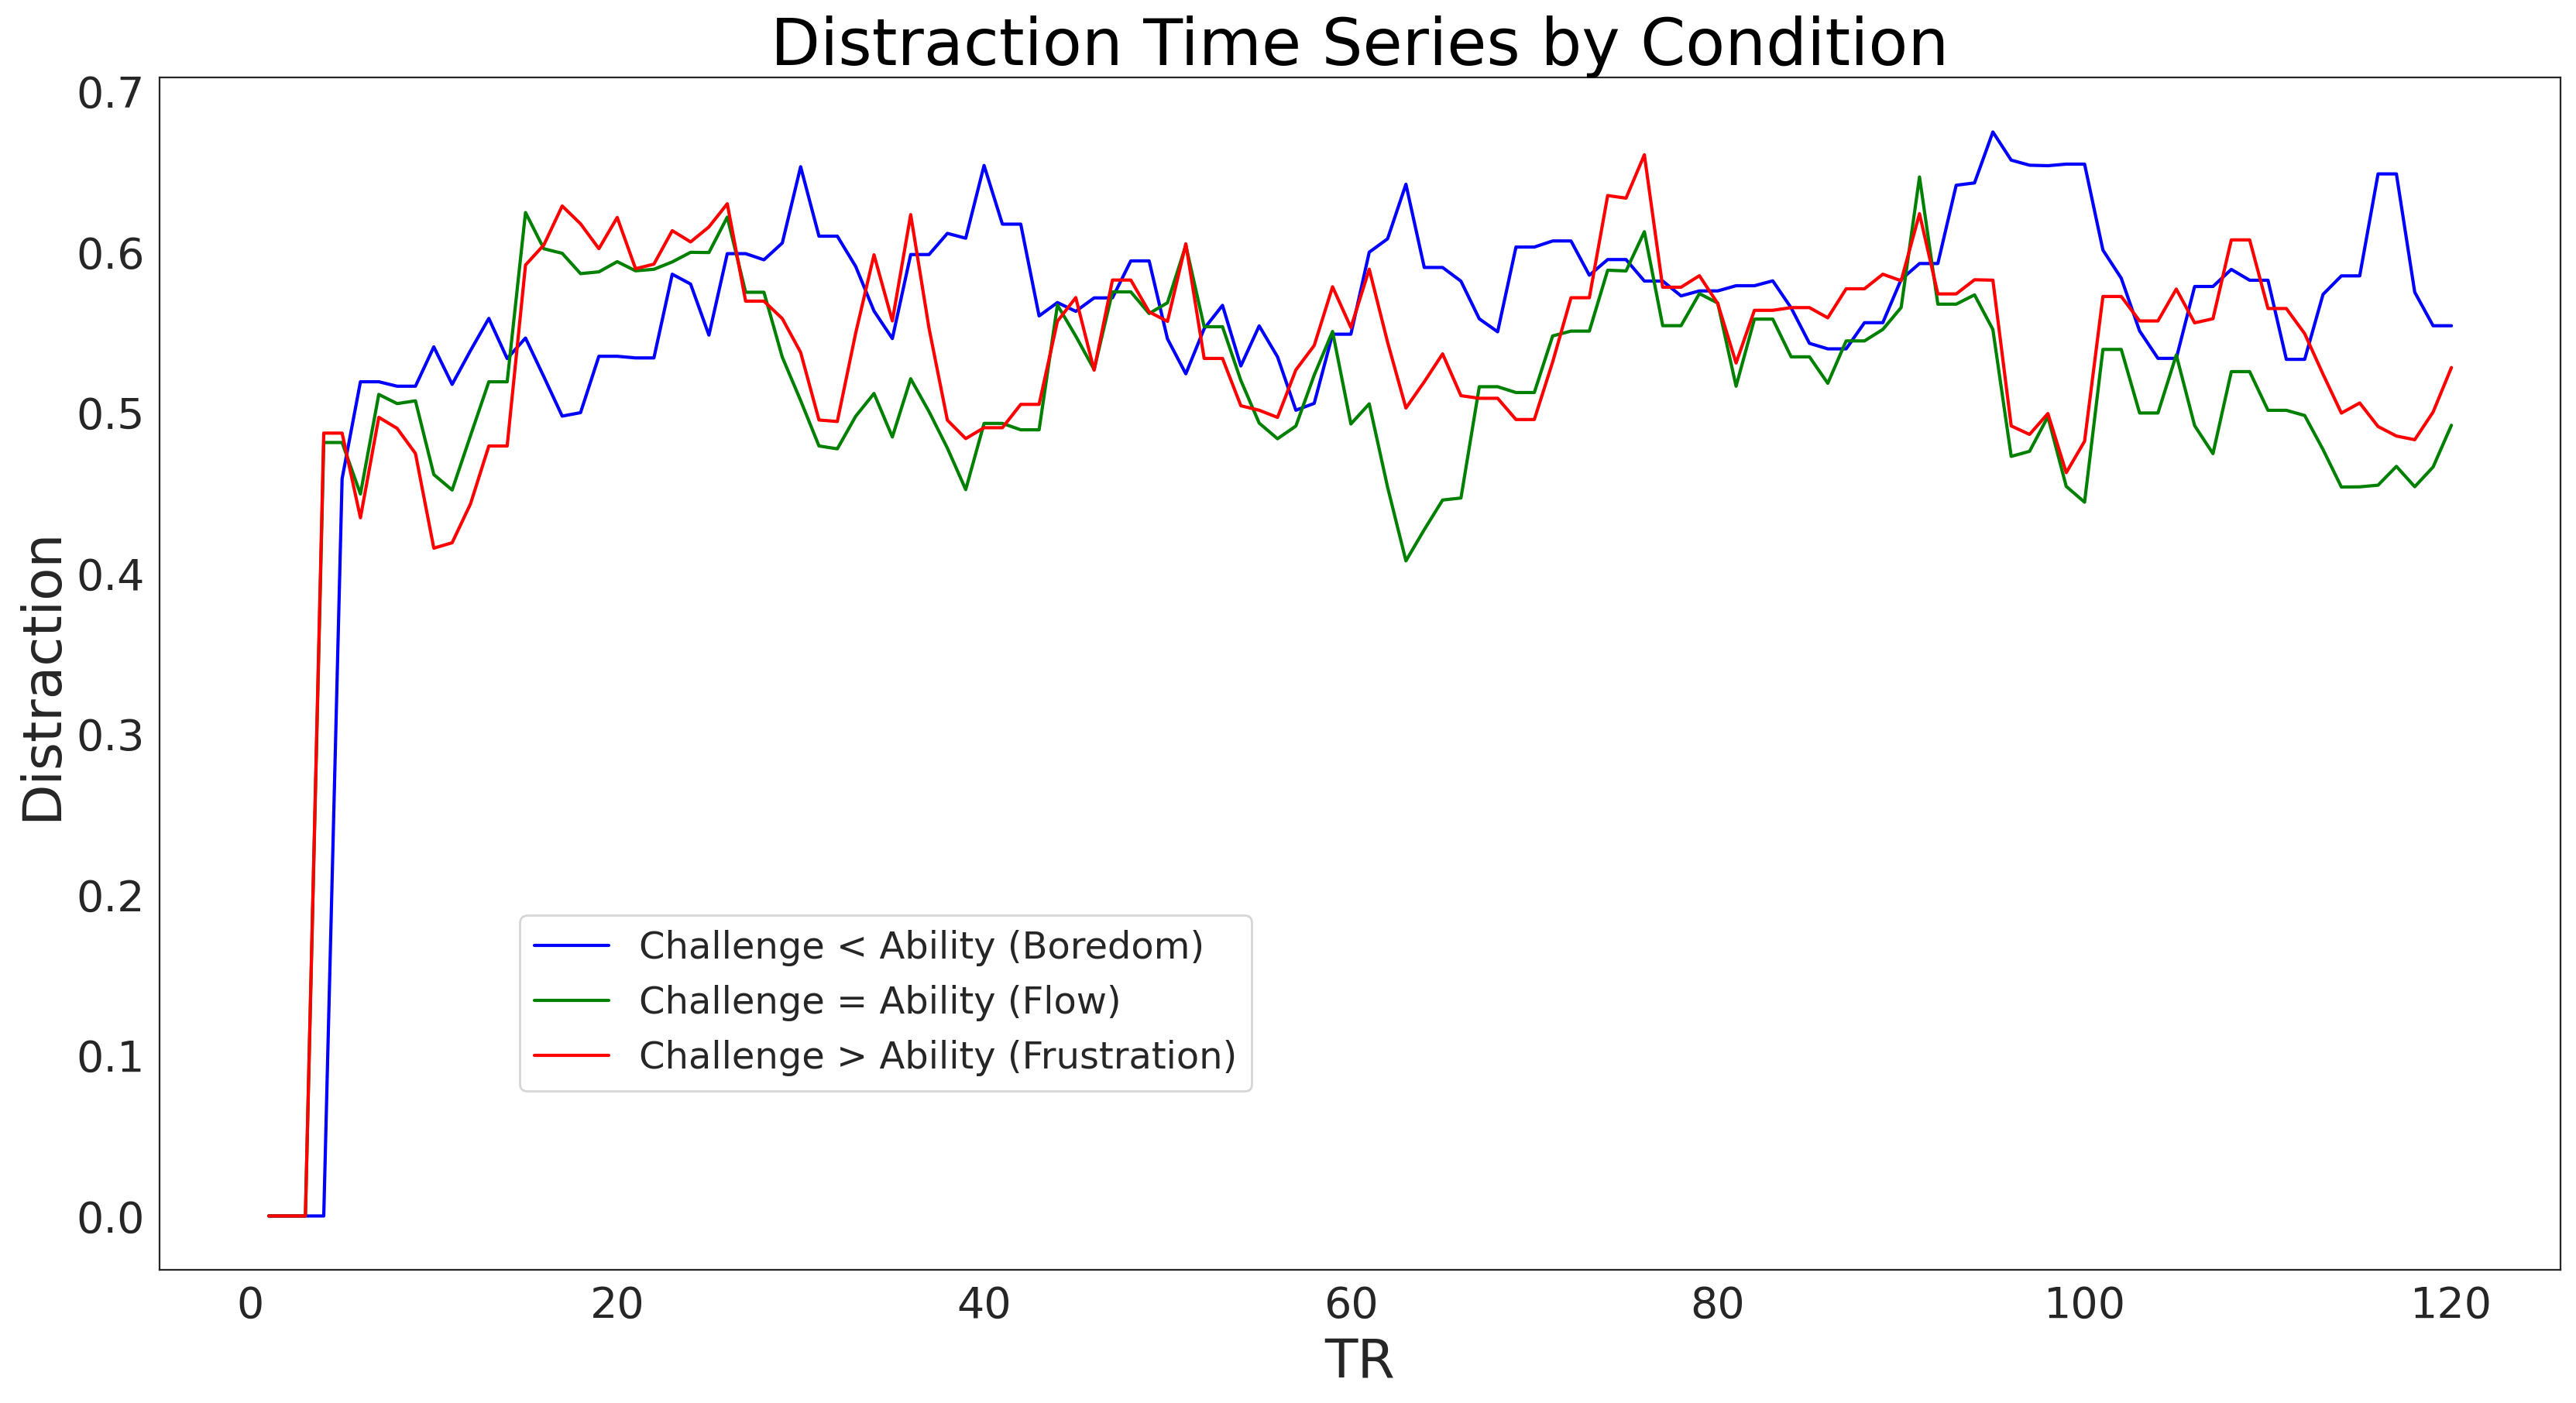

(array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120., 140.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

In [23]:
import matplotlib.pyplot as plt
plt.show() 

import seaborn as sns
sns.set_style('white')

x=[i for i in np.arange(1,121)]

plt.figure(figsize=(20,10), dpi=200)

plt.plot(x, bore, 'blue', label='Challenge < Ability (Boredom)', alpha=1)
plt.plot(x, flow, 'green', label='Challenge = Ability (Flow)', alpha=1)
plt.plot(x, frust, 'red', label='Challenge > Ability (Frustration)', alpha=1)

plt.legend(loc=(0.15, 0.15), fontsize='xx-large', ncol=1)
plt.title('Distraction Time Series by Condition', fontdict={'color': 'black','size': 20}, fontsize=30)
plt.xlabel('TR', fontsize=25)
plt.ylabel('Distraction', fontsize=25)
# plt.ylim(-4.7,0.5)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)


# plt.savefig(path + '/figs/index_morality.png')

### Save Distraction

We will be adding in the "dead" blank time in which we are not evaluating the subject's distraction data. This includes time at the beginning of the scan sequence, prior to gameplay, as well as time at the end of the scan sequence, after gameplay, during the survey. 

Below is the structure of the scan in consecutive TRs:

- TR 1-10 = begin scan sequence = 20 seconds
- TR 11-130 = gameplay duration = 240 seconds
- TR 131-140 = "Please answer the following questions in relation..." = 20 seconds
- TR 141-145 = survey q1 = 10 seconds
- TR 146-150 = survey q2 = 10 seconds
- TR 151-155 = survey q3 = 10 seconds
- TR 156-160 = survey q4 = 10 seconds
- TR 161-165 = survey q5 = 10 seconds
- TR 166-170 = survey q6 = 10 seconds
- TR 171-175 = survey q7 = 10 seconds
- TR 176-180 = survey q8 = 10 seconds
- TR 181-185 = "You are now finished with this part of the study." = 10 seconds

From this, we can see that there are 20 seconds (10TRs) of "dead" time prior to gameplay and 20 + 10\*9 = 110 seconds (55 TRs) of dead time after gameplay. 

In [17]:
dist

,index,subject_number,subject_run,condition,rt_trial,showtime_millis,reaction_prompt_millis,isi_millis,reaction_prompt_millis_roll,isi_millis_roll,tr,distraction_millis,distraction_sec,distraction_sec_rnd
1,0 days 00:00:01,005,02,Boredom,NaN,NaN,NaN,NaN,NaN,NaN,1,0.000000e+00,0.000000,0.000
3,0 days 00:00:03,005,02,Boredom,NaN,NaN,NaN,NaN,NaN,NaN,2,0.000000e+00,0.000000,0.000
5,0 days 00:00:05,005,02,Boredom,1.0,NaN,NaN,NaN,608.0,NaN,3,0.000000e+00,0.000000,0.000
7,0 days 00:00:07,005,02,Boredom,1.0,NaN,NaN,NaN,608.0,NaN,4,0.000000e+00,0.000000,0.000
9,0 days 00:00:09,005,02,Boredom,2.0,NaN,NaN,NaN,512.0,4000.0,5,4.882813e-07,0.488281,0.488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25191,0 days 00:03:51,042,03,Frustration,66.0,231000.0,592.0,4000.0,699.0,4000.0,116,3.576538e-07,0.357654,0.358
25193,0 days 00:03:53,042,03,Frustration,66.0,NaN,NaN,NaN,832.0,4000.0,117,3.004808e-07,0.300481,0.300
25195,0 days 00:03:55,042,03,Frustration,67.0,235000.0,592.0,4000.0,752.0,4000.0,118,3.324468e-07,0.332447,0.332
25197,0 days 00:03:57,042,03,Frustration,67.0,NaN,NaN,NaN,592.0,4000.0,119,4.222973e-07,0.422297,0.422


In [18]:
bore = dist.groupby('condition').get_group('Boredom')[['distraction_sec','tr']].groupby('tr').mean()
flow = dist.groupby('condition').get_group('Flow')[['distraction_sec','tr']].groupby('tr').mean()
frust = dist.groupby('condition').get_group('Frustration')[['distraction_sec','tr']].groupby('tr').mean()

In [19]:
bore

,distraction_sec
tr,
1,0.000000
2,0.000000
3,0.000000
4,0.000000
5,0.458812
...,...
116,0.648540
117,0.648540
118,0.574929


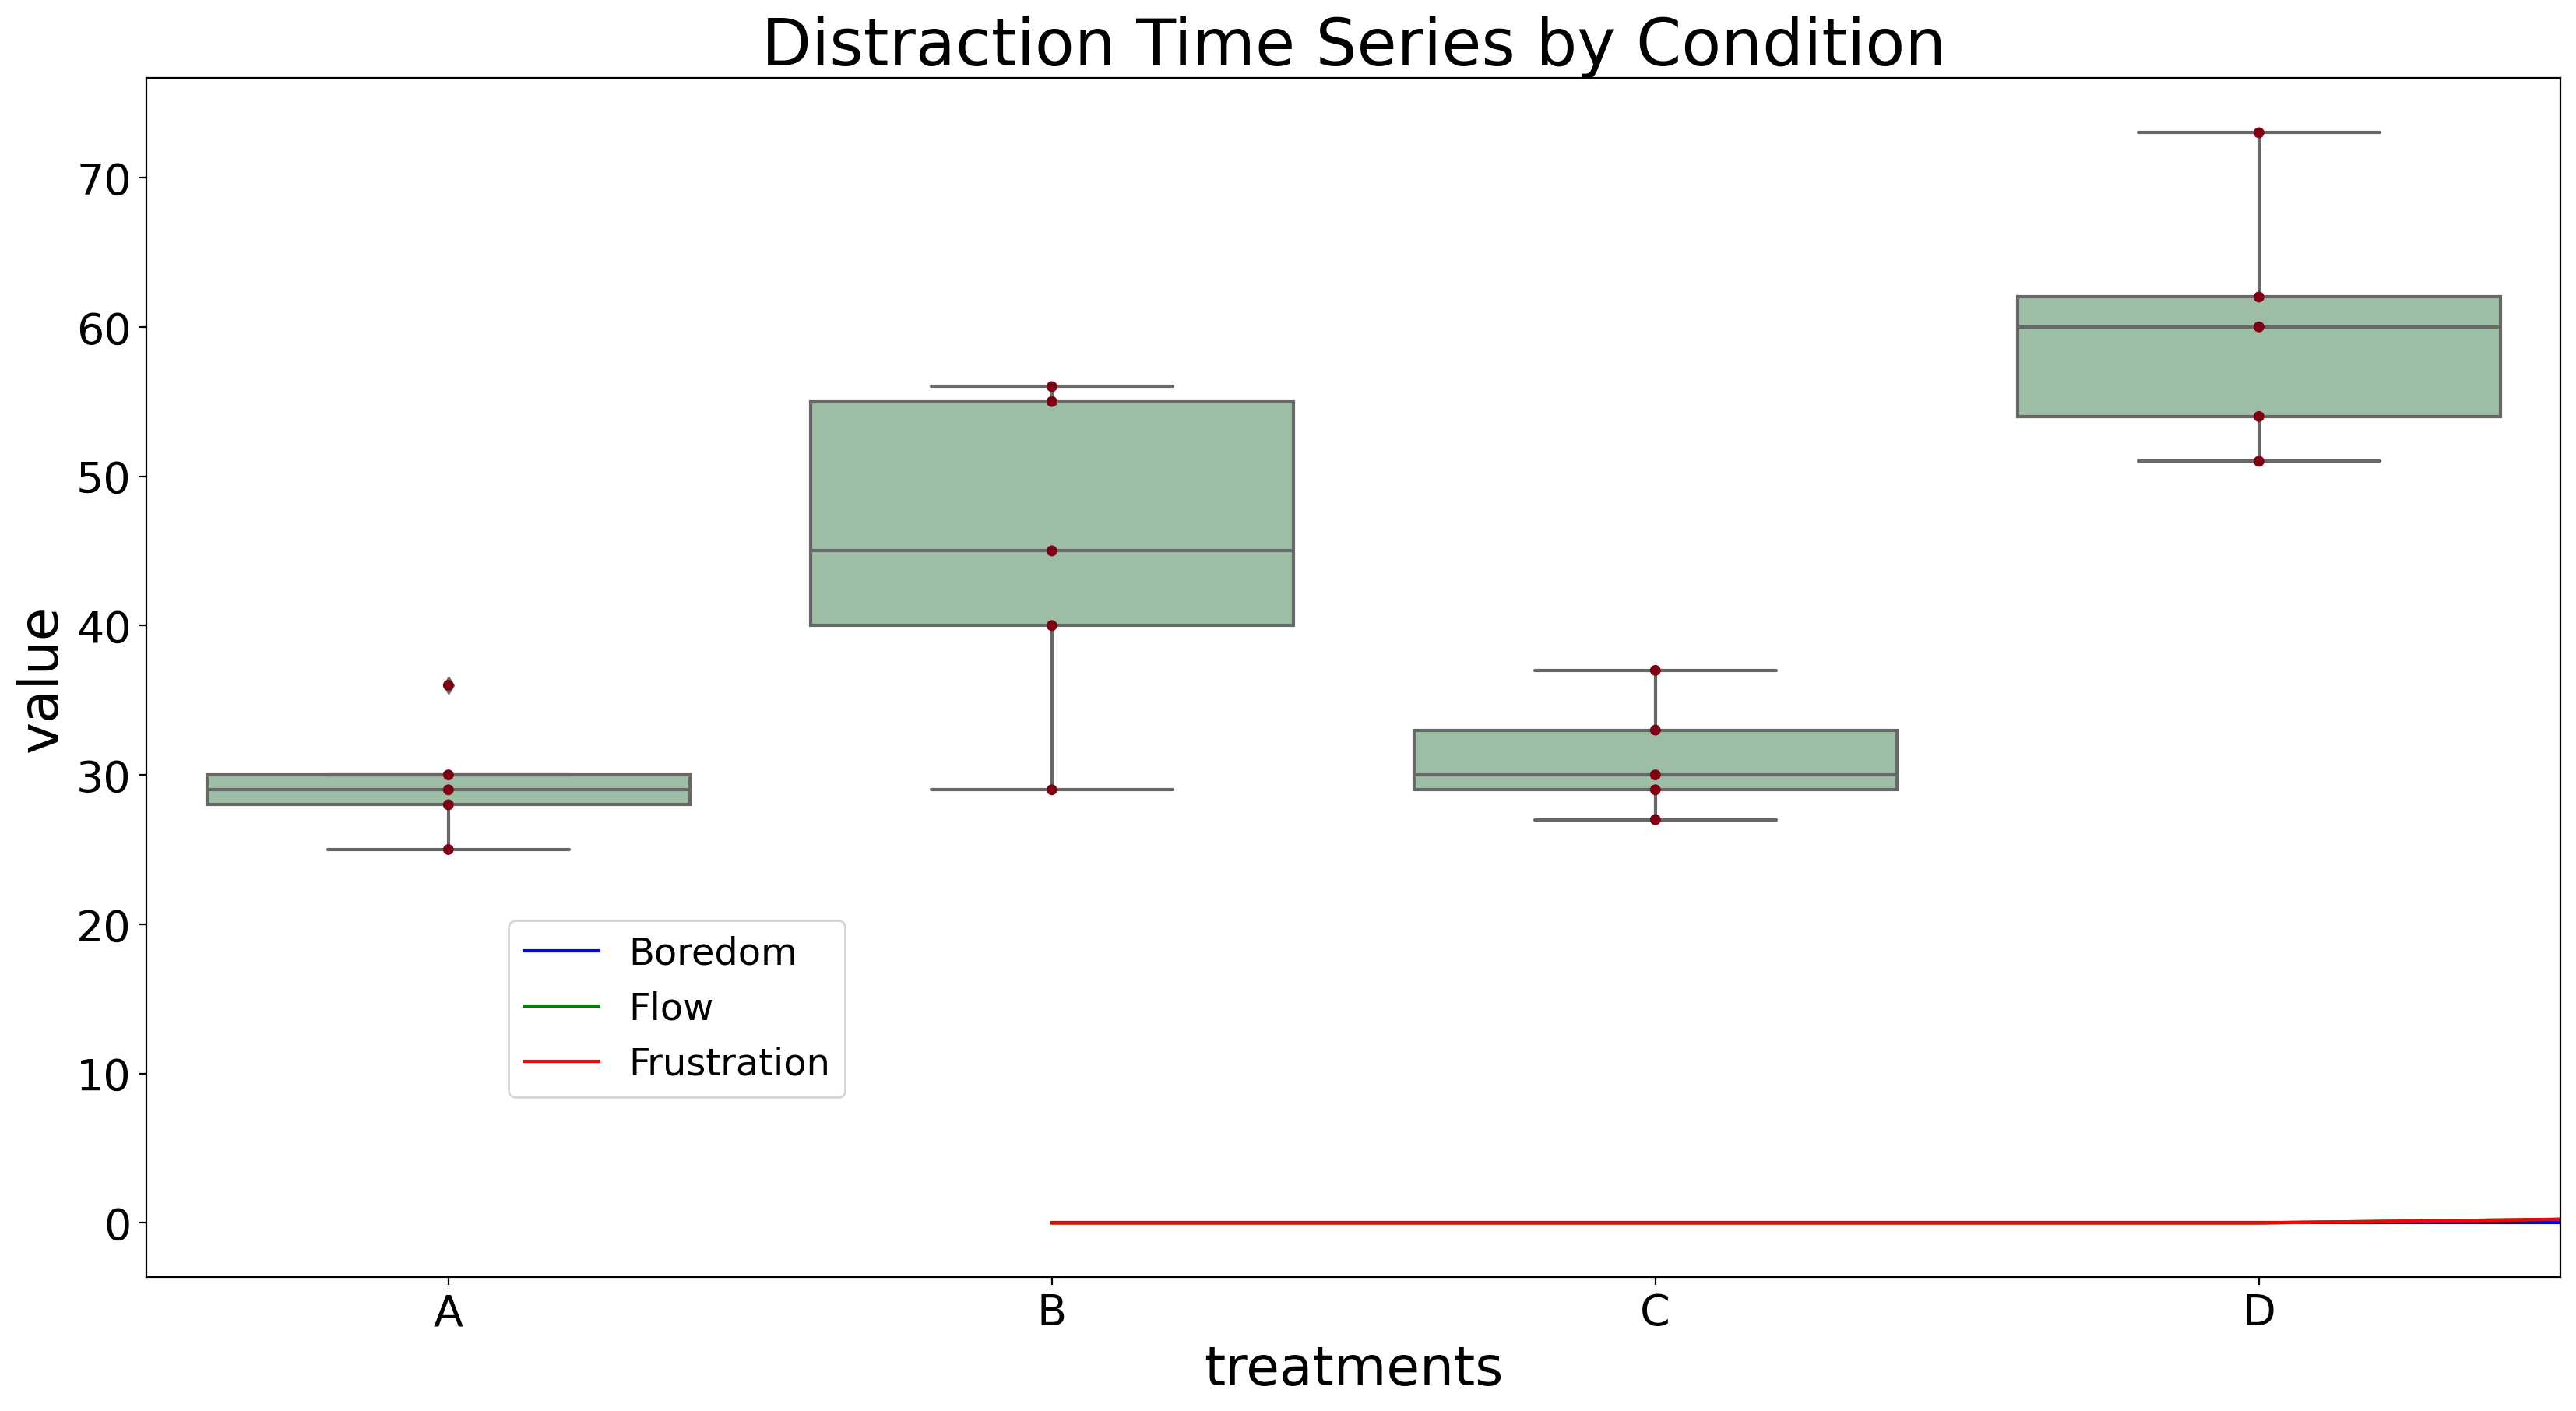

In [20]:
import pandas as pd
# load data file
df = pd.read_csv("https://reneshbedre.github.io/assets/posts/anova/onewayanova.txt", sep="\t")
# reshape the d dataframe suitable for statsmodels package 
df_melt = pd.melt(df.reset_index(), id_vars=['index'], value_vars=['A', 'B', 'C', 'D'])
# replace column names
df_melt.columns = ['index', 'treatments', 'value']

# generate a boxplot to see the data distribution by treatments. Using boxplot, we can 
# easily detect the differences between different treatments
import matplotlib.pyplot as plt
import seaborn as sns
ax = sns.boxplot(x='treatments', y='value', data=df_melt, color='#99c2a2')
ax = sns.swarmplot(x="treatments", y="value", data=df_melt, color='#7d0013')
plt.show()


In [45]:
# generate list of folder names, we are saving into the bids folder

from glob import glob
import os

bids_func = '/home/pw/projects/thesis/data/bids/sub-*'
bids = sorted(glob(bids_func))

# the amount of "dead" time to append to the beginning and end of the run
## 10 TRs for the beginning (20s)
## 55 TRs for the end (110s)
## 10 + 120 + 55 = 185 total TR

start = pd.Series([0]*10)
end = pd.Series([0]*55)

# add the distraction 
for folder in bids:
    for i, j in dist.groupby(['subject_number','subject_run'])['distraction_sec']:
        if i[0] == folder.split('sub-')[1]:
            # create a filepath for distraction per run
            fname = opj(folder, 'func', f'sub-{i[0]}_task-game_run-{i[1]}_events.tsv')
            # add blank space to beginning and end of data
            data = start.append(j).append(end).reset_index(drop=True)
            # save data
            if os.path.exists(fname)==True:
                print(f"File exists for sub{i[0]}-run{i[1]}.")
                os.remove(fname)
                print("File removed.")
            else:
                print("File does not exist.")
                data.to_csv(fname, header=False, index=False, sep="\t")
                print("File added.")
            

File does not exist.
File added.
File does not exist.
File added.
File does not exist.
File added.
File does not exist.
File added.
File does not exist.
File added.
File does not exist.
File added.
File does not exist.
File added.
File does not exist.
File added.
File does not exist.
File added.
File does not exist.
File added.
File does not exist.
File added.
File does not exist.
File added.
File does not exist.
File added.
File does not exist.
File added.
File does not exist.
File added.
File does not exist.
File added.
File does not exist.
File added.
File does not exist.
File added.
File does not exist.
File added.
File does not exist.
File added.
File does not exist.
File added.
File does not exist.
File added.
File does not exist.
File added.
File does not exist.
File added.
File does not exist.
File added.
File does not exist.
File added.
File does not exist.
File added.
File does not exist.
File added.
File does not exist.
File added.
File does not exist.
File added.
File does 